In [1]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from dictionary import AutoEncoder

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from typing import List, Tuple

/Users/ryansherby/opt/anaconda3/envs/pyML/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
one_gram_samples_df = pd.read_csv('data/1gram_samples.csv', delimiter=",", encoding="utf-8", quotechar='"')

one_gram_samples = one_gram_samples_df['gram'].tolist()

one_gram_targets_df = pd.read_csv('data/1gram_targets.csv', delimiter=",", encoding="utf-8", quotechar='"')

one_gram_targets = one_gram_targets_df['gram'].tolist()

two_grams_df = pd.read_csv('data/2grams.csv', delimiter=",", encoding="utf-8", quotechar='"')

two_grams = two_grams_df['gram'].tolist()

In [3]:
# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-2.8b-deduped")
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-2.8b-deduped")
tokenizer.pad_token = tokenizer.eos_token


The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


In [4]:
# Load Dictionary Learning AutoEncoder
ae = AutoEncoder.from_pretrained(
    "dictionaries/pythia-70m-deduped/mlp_out_layer3/10_32768/ae.pt", 
    map_location=torch.device('cpu')
)

/Users/ryansherby/Library/CloudStorage/OneDrive-Personal/Documents/Columbia/CRIS Lab Project/dictionary_learning/dictionary.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featur

In [5]:
activation_list = []

def hook_fn(module, input, output):
    activation_list.append(output)


layer_to_hook = model.gpt_neox.layers[3].mlp
hook = layer_to_hook.register_forward_hook(hook_fn)

In [6]:
input = tokenizer('sunset', return_tensors="pt", padding=True, truncation=True)
decoded_tokens = tokenizer.convert_ids_to_tokens(input['input_ids'][0])
output = model(**input)
t = activation_list[0][0].detach().numpy()
activation_list.clear()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [49]:

one_gram_samples_activations = []
one_gram_targets_activations = []
two_gram_activations = []

for one_gram in one_gram_samples[:500]: # TODO: Remove to slicer
    input = tokenizer(one_gram, return_tensors="pt", padding=True, truncation=True)
    decoded_tokens = tokenizer.convert_ids_to_tokens(input['input_ids'][0])
    output = model(**input)
    one_gram_samples_activations.append((activation_list[0][0].detach().numpy()[-1],decoded_tokens[-1])) # Take only last vector
    activation_list.clear()


for one_gram in one_gram_targets[:500]: # TODO: Remove to slicer
    input = tokenizer(one_gram, return_tensors="pt", padding=True, truncation=True)
    decoded_tokens = tokenizer.convert_ids_to_tokens(input['input_ids'][0])
    output = model(**input)
    one_gram_targets_activations.append((activation_list[0][0].detach().numpy()[-1],decoded_tokens[-1])) # Take only last vector
    activation_list.clear()


for two_gram in two_grams[:500]: # TODO: Remove to slicer
    input = tokenizer(two_gram, return_tensors="pt", padding=True, truncation=True)
    decoded_tokens = tokenizer.convert_ids_to_tokens(input['input_ids'][0]) 
    output = model(**input)
    two_gram_activations.append((activation_list[0][0].detach().numpy()[-1],decoded_tokens[-1])) # Take only last vector
    activation_list.clear()

KeyboardInterrupt: 

In [ ]:
# Convert activations to sparse representations
"""
one_gram_samples_sparse = []
one_gram_targets_sparse = []
two_gram_sparse = []

coll1 = [one_gram_samples_sparse, one_gram_targets_sparse, two_gram_sparse]
coll2 = [one_gram_samples_activations, one_gram_targets_activations, two_gram_activations]

for idx,tup in enumerate(coll2):
    for activations,token in tup:
        sparse_rep = ae.encode(torch.tensor(activations)).detach().cpu().numpy()
        coll1[idx].append((sparse_rep,token))
"""

#TODO: Update dict to match 2.8b model

'\none_gram_samples_sparse = []\none_gram_targets_sparse = []\ntwo_gram_sparse = []\n\ncoll1 = [one_gram_samples_sparse, one_gram_targets_sparse, two_gram_sparse]\ncoll2 = [one_gram_samples_activations, one_gram_targets_activations, two_gram_activations]\n\nfor idx,tup in enumerate(coll2):\n    for activations,token in tup:\n        sparse_rep = ae.encode(torch.tensor(activations)).detach().cpu().numpy()\n        coll1[idx].append((sparse_rep,token))\n'

In [ ]:
# Stack the samples
# X = torch.tensor(np.hstack([np.array(list(a for a,x in one_gram_samples_activations)),np.array(list(a for a,x in two_gram_activations))])) # Row vectors
X = torch.tensor(np.array(list(a for a,x in two_gram_activations))) # Row vectors
Y = torch.tensor(np.array(list(a for a,x in one_gram_targets_activations))) # Row vectors

# Unique sentiments
k = one_gram_samples_df['gram'][0:500].nunique() # TODO: Remove to slicer

In [ ]:
k

3

In [ ]:


class CustomEncoder(torch.nn.Module):
    def __init__(self, input_size, output_size, k=64):
        super(CustomEncoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, k,bias=True),
            torch.nn.ReLU(),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(k, output_size, bias=True),
        )

    def forward(self, x):
        f = self.encoder(x)
        y = self.decoder(f)
        return y, f
    
class LossFunction(torch.nn.Module):
    def __init__(self, lambda_=0.1):
        super(LossFunction, self).__init__()

        self.lambda_ = lambda_

    def forward(self, x, x_hat, f):
        reconstruction_error = torch.mean(torch.norm(x - x_hat, p=2)**2)

        # magnitude_penalty = self.lambda_ * torch.mean(torch.norm(torch.abs(f), p=1))
        # abs not strictly necessary because of ReLU in encoder

        return reconstruction_error # + magnitude_penalty


    

# Train the autoencoder
ce = CustomEncoder(X.shape[1], Y.shape[1], k)

criterion = LossFunction(lambda_=0.1)

optimizer = torch.optim.Adam(ce.parameters(), lr=0.001)

for idx,sample in enumerate(X):
    y_pred, f = ce(sample)
    loss = criterion(Y[idx], y_pred, f)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"Loss: {loss.item()}")

Loss: 710.0576782226562
Loss: 3577.33837890625
Loss: 514.9641723632812
Loss: 3342.13525390625
Loss: 3625.471435546875
Loss: 644.80908203125
Loss: 3535.410400390625
Loss: 544.2198486328125
Loss: 496.6161193847656
Loss: 639.6327514648438
Loss: 3457.55126953125
Loss: 3078.569091796875
Loss: 3527.322021484375
Loss: 3554.072509765625
Loss: 3314.8046875
Loss: 3543.705322265625
Loss: 3520.89208984375
Loss: 645.5652465820312
Loss: 3578.0087890625
Loss: 3397.528076171875
Loss: 3453.60009765625
Loss: 3356.475830078125
Loss: 3603.24853515625
Loss: 3565.987060546875
Loss: 3457.6005859375
Loss: 3491.415283203125
Loss: 3491.451416015625
Loss: 3417.98046875
Loss: 3514.22314453125
Loss: 502.96844482421875
Loss: 3288.687255859375
Loss: 3597.172607421875
Loss: 3503.4794921875
Loss: 3516.310791015625
Loss: 3622.755126953125
Loss: 3391.655517578125
Loss: 3430.712158203125
Loss: 3384.229248046875
Loss: 643.5120239257812
Loss: 620.7940673828125
Loss: 3544.88671875
Loss: 3364.678955078125
Loss: 3551.70654296

In [ ]:
dictionary = ce.decoder[0].weight.detach().numpy().T # k x activation_dim ; Row Vectors

In [ ]:
def cosine_similarity_matrix(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    """
    Compute the cosine similarity between two matrices of row vectors.

    Parameters:
        A (np.ndarray): A 2D numpy array of shape (n_samples_A, n_features)
        B (np.ndarray): A 2D numpy array of shape (n_samples_B, n_features)

    Returns:
        np.ndarray: A 2D numpy array of shape (n_samples_A, n_samples_B) 
                    where each entry [i, j] is the cosine similarity between
                    A[i] and B[j]
    """
    # Compute the dot product between each pair of rows in A and B
    dot_product = np.dot(A, B.T)
    
    # Compute the L2 norms (Euclidean norms) for each row vector in A and B
    norm_A = np.linalg.norm(A, axis=1, keepdims=True)  # shape: (n_samples_A, 1)
    norm_B = np.linalg.norm(B, axis=1, keepdims=True)  # shape: (n_samples_B, 1)
    
    # To avoid division by zero, set any zero norms to a very small value
    eps = 1e-10
    norm_A = np.maximum(norm_A, eps)
    norm_B = np.maximum(norm_B, eps)
    
    # Compute the cosine similarity matrix
    cosine_sim = dot_product / (norm_A * norm_B.T)
    return cosine_sim

In [ ]:
one_gram_matrix = np.vstack([x for x,_ in one_gram_targets_activations])

In [ ]:
one_gram_matrix.shape

(50, 2560)

In [ ]:
two_gram_matrix = np.vstack([x for x,_ in two_gram_activations])

In [ ]:
baseline = cosine_similarity_matrix(one_gram_matrix, two_gram_matrix)

<Axes: >

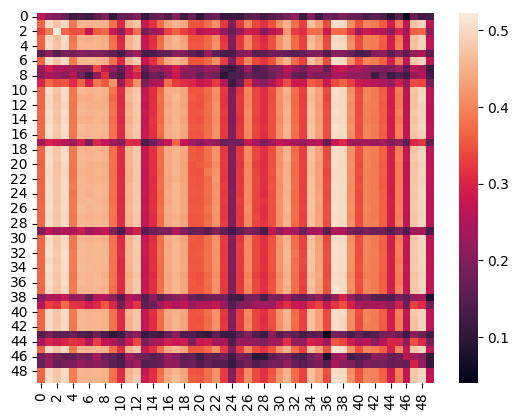

In [ ]:
sns.heatmap(baseline)

In [ ]:
dict_vec_target_improvements:List[List[float]] = []
dict_vec_all_improvements:List[List[List[float]]] = []



for vec in dictionary:
    vec = vec.reshape(1,-1)
    
    shifted_one_gram_matrix = one_gram_matrix + vec # Additive shift
    
    cos = cosine_similarity_matrix(shifted_one_gram_matrix, two_gram_matrix)

    adv = cos - baseline
    
    print(adv.diagonal())

    dict_vec_target_improvements.append(list((idx,a) for idx,a in enumerate(adv.diagonal()) if a > 0))
    # Vectors where vector shift resulted in targeted improvement

    # dict_vec_all_improvements.append([row[row > 0].tolist() for row in adv]) #TODO: Better data structure
    # Vectors where vector shift resulted in any improvement

    



[-0.07155575 -0.02284557 -0.16509277 -0.02953225 -0.01389077 -0.05683187
 -0.018942   -0.1007693  -0.10910195 -0.09199306 -0.01264098 -0.02470449
 -0.01726896 -0.01325902 -0.01525578 -0.01501784 -0.02047804 -0.07270765
 -0.01609123 -0.0222694  -0.01458046 -0.0141508  -0.01302841 -0.01388887
 -0.00936849 -0.00481126 -0.02038455 -0.01633623 -0.00713304 -0.06989166
 -0.01218671 -0.0267967  -0.01649675 -0.01154894 -0.01925361 -0.02030122
 -0.0095475  -0.01487592 -0.06556495 -0.07658143 -0.01202771 -0.01618868
 -0.01683706 -0.03186381 -0.05726869 -0.01578334 -0.05305903 -0.06190088
 -0.02309501 -0.01933193]
[-0.05382749 -0.01952446 -0.1470477  -0.01137832 -0.01722324 -0.03402093
 -0.01390952 -0.09334068 -0.07346384 -0.09128532 -0.00935781 -0.02017051
 -0.02040851 -0.0014326  -0.01392218 -0.01386872 -0.01454696 -0.09363797
 -0.01237968 -0.01493606 -0.00779158 -0.00949928 -0.00608468 -0.00503218
 -0.00226057 -0.00623283 -0.01698077 -0.01715848 -0.00451171 -0.06266826
 -0.01426023 -0.01206154 

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

token_value_by_dict_vec = []

for i in range(len(dictionary)):

    vals = sorted(dict_vec_target_improvements[i],reverse=True, key=lambda x: x[1])

    tokens = {}

    for idx, val in vals:
        tokens[one_gram_samples[idx]] = tokens.get(one_gram_samples[idx],0) + val

    token_value_by_dict_vec.append(tokens)

In [ ]:
token_value_by_dict_vec

[{}, {}, {}]

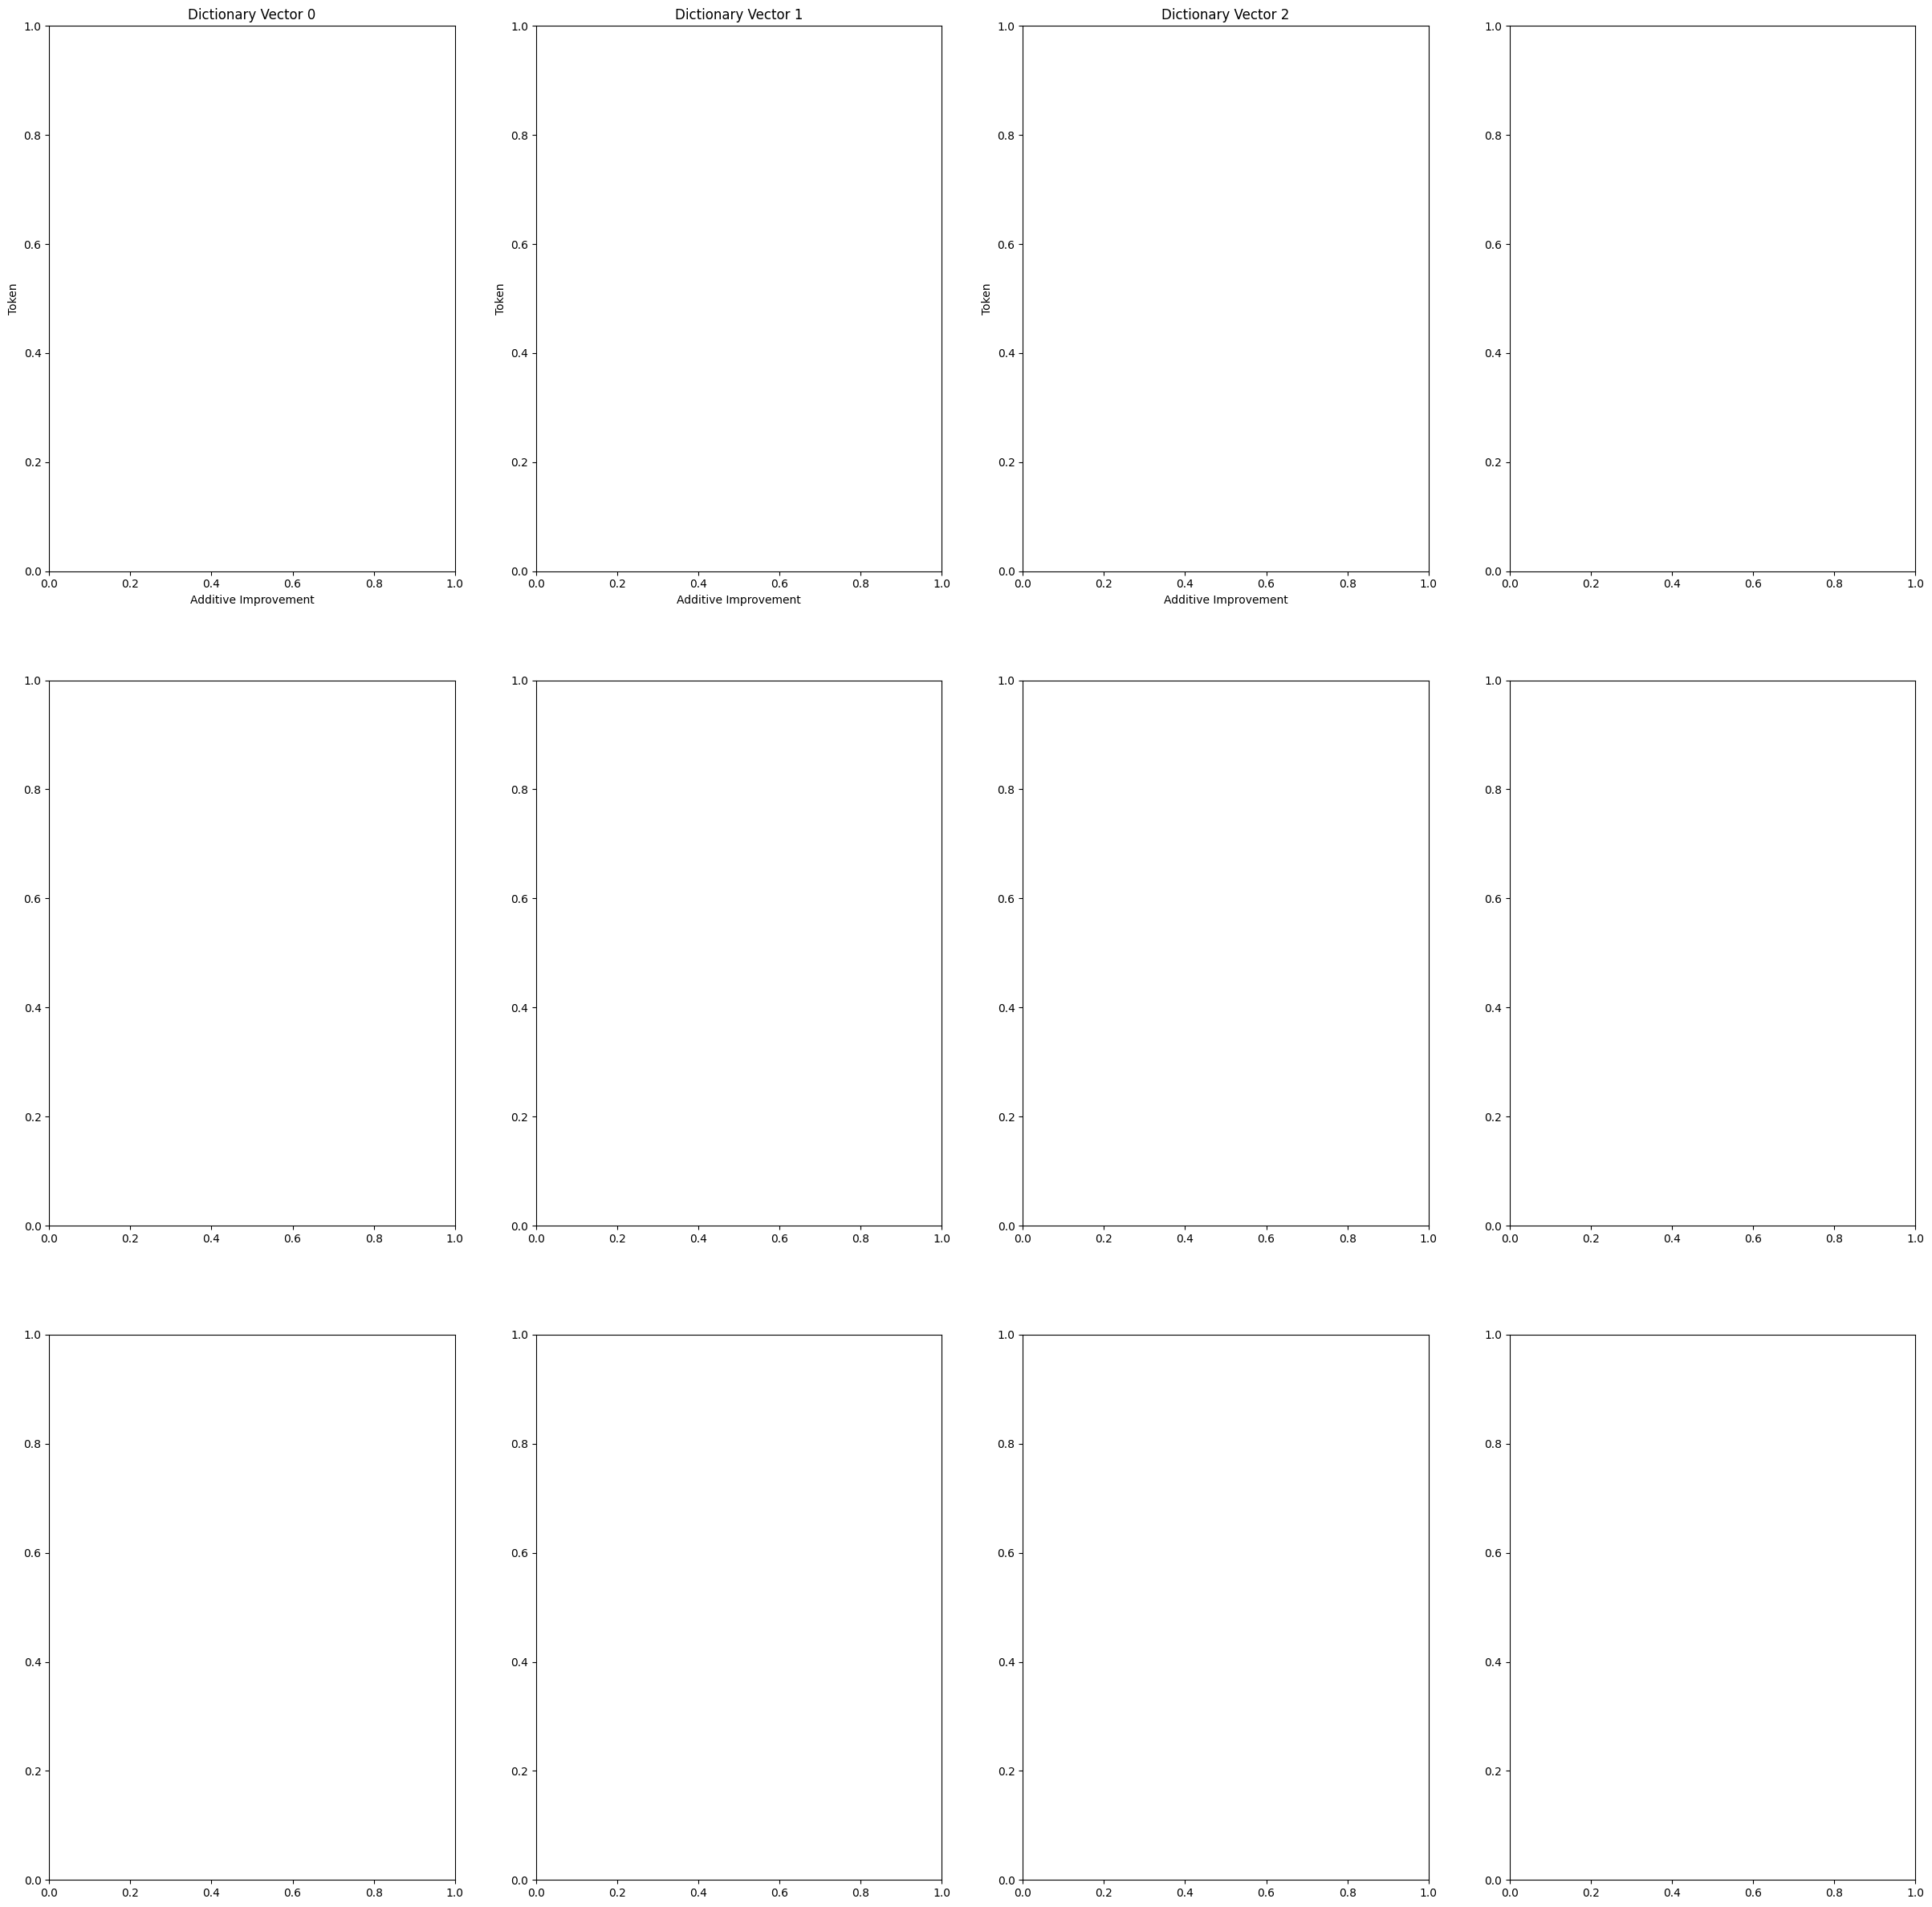

In [ ]:
fig, ax = plt.subplots(3,4,figsize=(30, 30))    


ax = ax.flatten()

for i,token in enumerate(token_value_by_dict_vec):
    sns.barplot(x=list(tokens.values()),y=list(tokens.keys()),ax=ax[i])
    ax[i].set_title(f"Dictionary Vector {i}")
    ax[i].set_ylabel("Token")
    ax[i].set_xlabel("Additive Improvement")

In [50]:
# Total Additive Improvement
# Degree of High Improvement (Normalized) for Specific Tokens; Entropy